In [1]:
import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pandas.plotting import autocorrelation_plot
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from scipy.stats import zscore, kurtosis, skew
from custom_functions import clip_outliers, compute_latest_corr_matrix, compute_rolling_portfolio_volatility, describe_shape
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import copy
import math
from config import CONFIG
import random
import os


In [2]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(7)

In [3]:
df = pd.read_csv("data/combined_stock_data_wide.csv", parse_dates=["Date"])

# Set datetime index
df.set_index("Date", inplace=True)


df.dropna(inplace=True) #dropping all nulls

# Extract closing prices
close_cols = [col for col in df.columns if col.endswith("_Close") and "Adj" not in col]
volume_cols = [col for col in df.columns if col.endswith("_Volume")]

close_df = df[close_cols]
volume_df = df[volume_cols]

<big>Exploratory Data Analysis + Feature Engineering<big>

HHS.VN_Volume    0
HAH.VN_Volume    0
VCB.VN_Volume    0
VIX.VN_Volume    0
LPB.VN_Volume    0
YEG.VN_Volume    0
dtype: int64


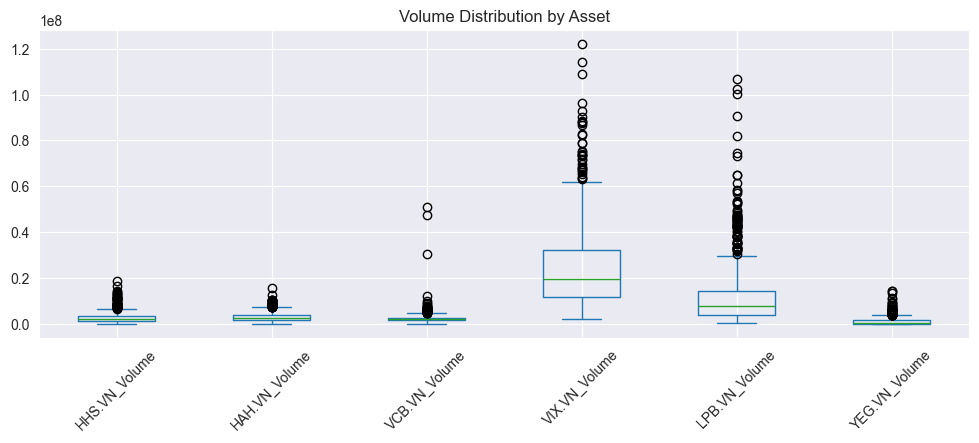

In [4]:
# Count zero volumes
print((volume_df == 0).sum().sort_values(ascending=False))

# Boxplot to see volume outliers
volume_df.plot(kind='box', figsize=(12, 4), title="Volume Distribution by Asset")
plt.xticks(rotation=45)
plt.show()

LPB, HPG, and VIX has high amount of outliers, and a lot of outliers, so I should not just remove them but rather transform them into logarithm form

In [5]:
# Log volume ---
log_volume = np.log1p(volume_df).diff()
log_volume.dropna(inplace=True) # diff() creates 1 null

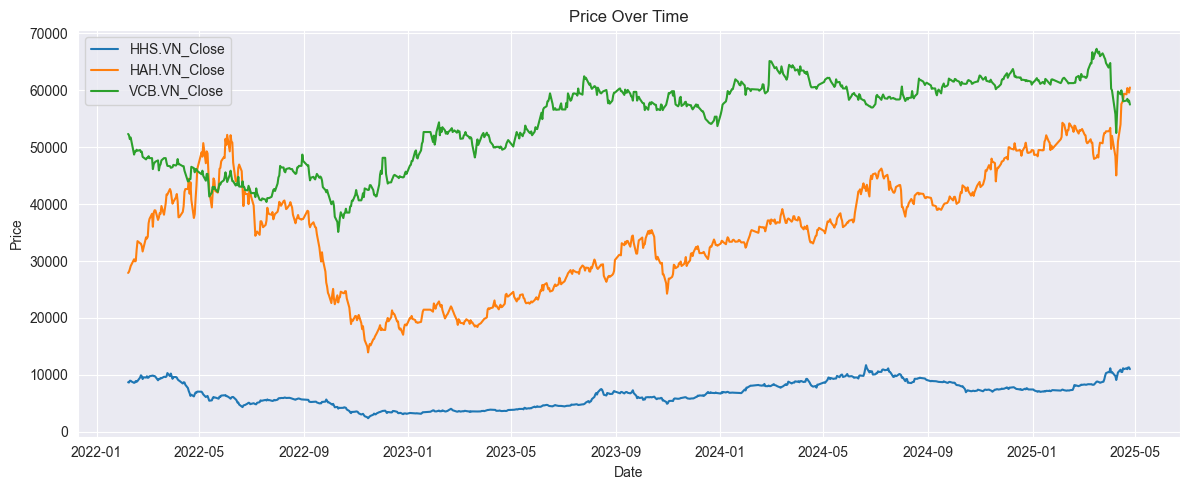

In [6]:
# Plot raw price to show non-stationarity
plt.figure(figsize=(12, 5))
for col in close_cols[:3]:
    plt.plot(close_df[col], label=col)
plt.title("Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The data is non-stationary, as expected with the nature of stock price, meaning I have to transform it into a close-to-stationary form, which I used log returns

In [7]:
# Compute raw log returns and keep them separate
raw_log_returns = np.log(close_df / close_df.shift(1))

# Create the target BEFORE any other feature engineering
future_returns = raw_log_returns.shift(-1)

# Renaming the columns in future_returns to avoid conflicts
future_returns.columns = ['future_' + col for col in future_returns.columns]

# Apply outlier clipping and drop NA values
future_returns = clip_outliers(future_returns)
future_returns.dropna(inplace=True)

# Feature engineering happens completely separately
log_returns = raw_log_returns.copy()


In [8]:
# Risk indicator
rolling_std = raw_log_returns.rolling(window=15).std()  # start with 10, tune later
rolling_std = rolling_std.add_suffix('_risk')  # rename cols to avoid collision

# Add it to target
future_risks = rolling_std.shift(-1)
future_risks=future_risks.add_prefix('future_')

future_risks.dropna(inplace=True)

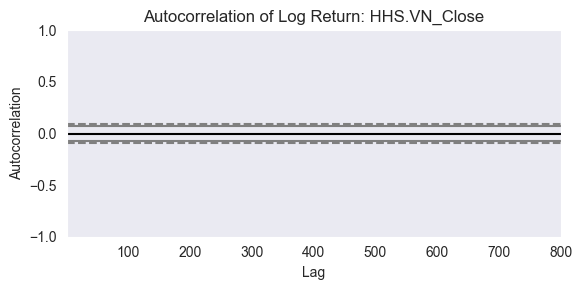

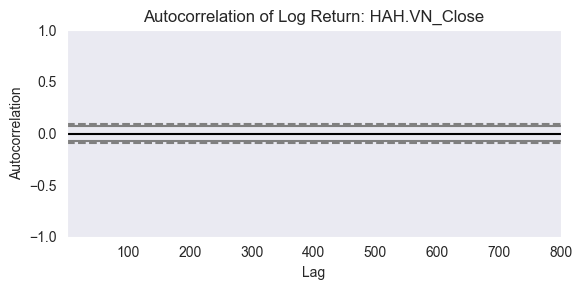

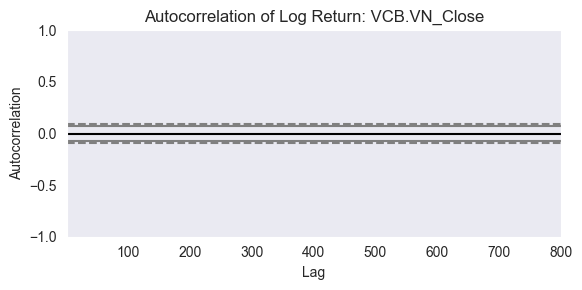

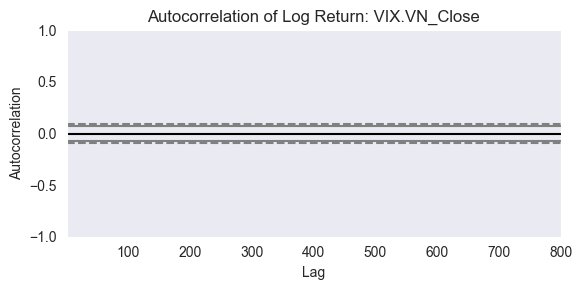

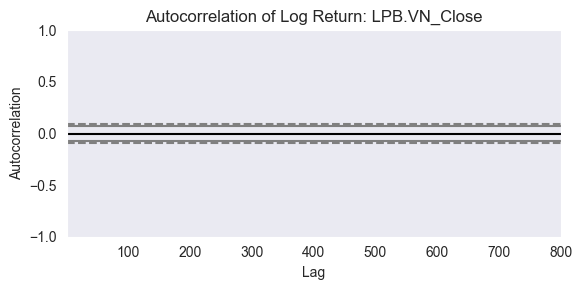

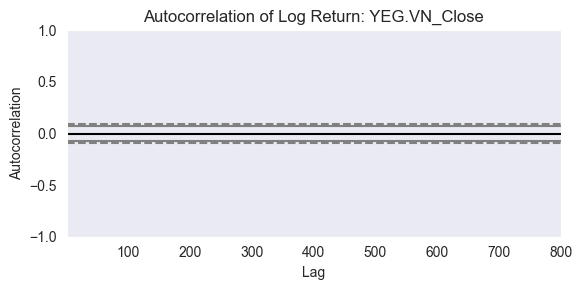

In [9]:
# autocorrelation of log returns
for col in raw_log_returns.columns:
    plt.figure(figsize=(6, 3))
    autocorrelation_plot(raw_log_returns[col])
    plt.title(f'Autocorrelation of Log Return: {col}')
    plt.tight_layout()
    plt.show()

No autocorrelation, but that doesn't mean we shouldn't add lagged feature or rolling features, because mathematically, autocorrelation only captures linear dependencies, which isn't true with stock data. So I'm going to experiment with many cases with the toggles below

<big>Toggle<big>

In [10]:
# --- Toggle which features to include ---
include_regime_labels = False
use_one_hot_regime = False  # if False, use ordinal encoding
include_momentum = True
include_liquidity_proxy = True

This is for turning on or off block (used for adding, removing features)

In [11]:
# --- Feature Block: Regime Labeling ---
def label_regime(series, short_window=15, long_window=40):
    short_ma = series.rolling(window=short_window).mean()
    long_ma = series.rolling(window=long_window).mean()
    label = np.where(short_ma > long_ma, "bull", 
             np.where(short_ma < long_ma, "bear", "sideway")) # else short_ma==long_ma -> sideway
    return pd.Series(label, index=series.index)

regime_dummies = pd.DataFrame()

if include_regime_labels:
    market_proxy = close_df[close_cols[0]]
    regime_labels = label_regime(market_proxy)

    if use_one_hot_regime:
        regime_dummies = pd.get_dummies(regime_labels, prefix="regime").astype(float)
    else:   
        regime_map = {"bear": -1, "sideway": 0, "bull": 1}  # ordinal encoding
        regime_encoded = regime_labels.map(regime_map)
        regime_dummies = regime_encoded.to_frame(name="regime_encoded")

In [12]:
# --- Feature Block: Momentum ---

momentum_features = pd.DataFrame()

if include_momentum:
    momentum = np.log(close_df) - np.log(close_df.shift(15))
    momentum.columns = [col + "_momentum" for col in momentum.columns]
    momentum.dropna(inplace=True)
    momentum_features = momentum

In [13]:
# --- Feature Block: Liquidity ---

liquidity_proxy = pd.DataFrame()

if include_liquidity_proxy:
    liquidity_proxy = log_volume.rolling(window=15).mean()
    liquidity_proxy.columns = [col.replace("_Volume", "_liq_proxy") for col in liquidity_proxy.columns]
    liquidity_proxy.dropna(inplace=True)

Target Construction


Descriptive stats for future returns (post-clipping):
       future_HHS.VN_Close  future_HAH.VN_Close  future_VCB.VN_Close  \
count           799.000000           799.000000           799.000000   
mean              0.000295             0.000968             0.000135   
std               0.029458             0.029172             0.014138   
min              -0.072510            -0.082279            -0.048359   
25%              -0.011835            -0.013001            -0.007059   
50%               0.000000             0.001211             0.000000   
75%               0.014113             0.015998             0.006708   
max               0.067620             0.067586             0.048008   

       future_VIX.VN_Close  future_LPB.VN_Close  future_YEG.VN_Close  
count           799.000000           799.000000           799.000000  
mean             -0.000439             0.000915            -0.000015  
std               0.032842             0.024425             0.034692  
min         

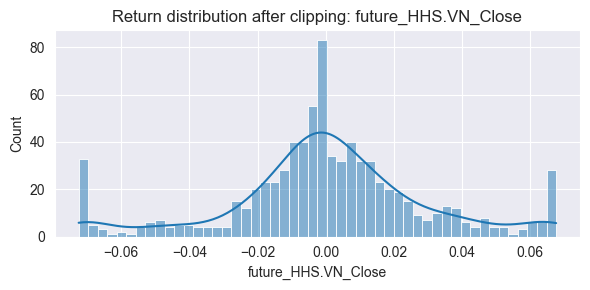

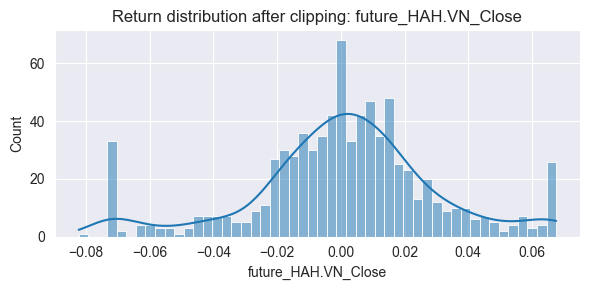

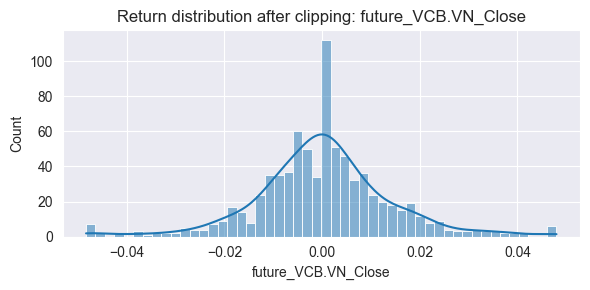

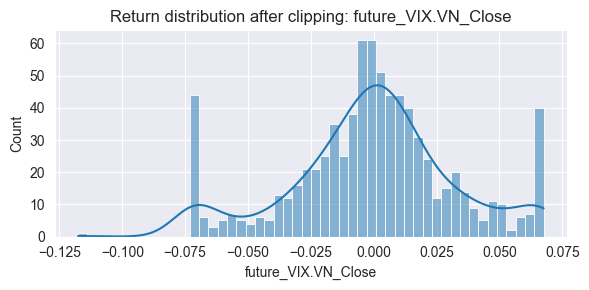

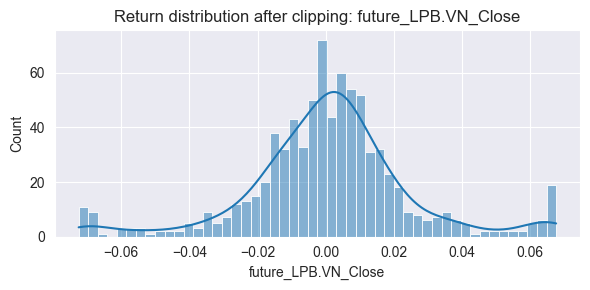

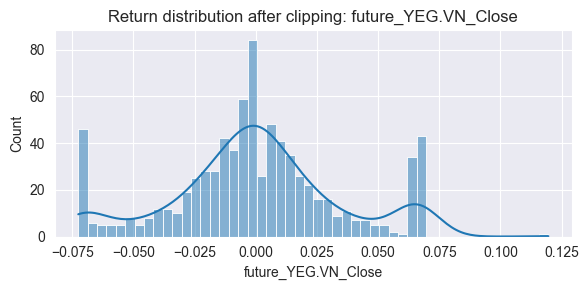

In [15]:
print("\nDescriptive stats for future returns (post-clipping):")
filtered_cols = [col for col in future_returns.columns]
print(future_returns[filtered_cols].describe())

for col in filtered_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(future_returns[col], kde=True, bins=50)
    plt.title(f"Return distribution after clipping: {col}")
    plt.tight_layout()
    plt.show()


The distribution is mostly normal, except for skewness in the tails. However, this is expected and doesn't strictly violate the assumptions of LSTM

The distribution is mostly not normal, and this is expected and not problematic. This is because LSTM is flexible and does not assume normality in the data 

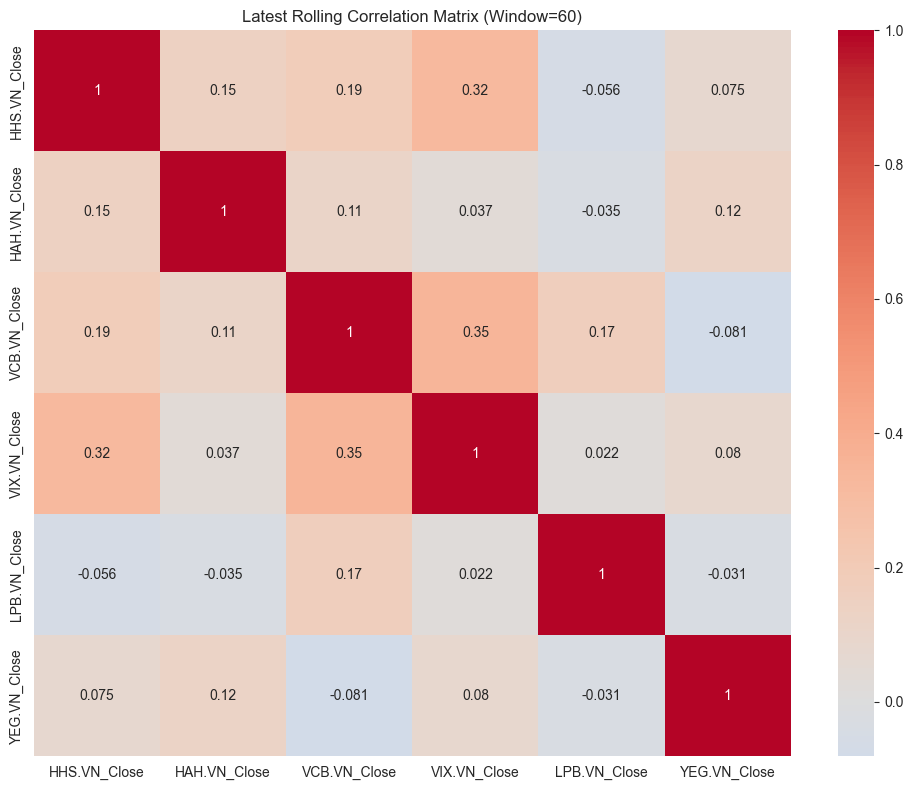

In [16]:
# Exclude last 20 trading days for correlation analysis because of the recent market crash that makes it hard to see the real correlation between assets
cleaned_df = log_returns.iloc[:-20]
latest_corr = compute_latest_corr_matrix(cleaned_df[close_cols], window=80)

plt.figure(figsize=(10, 8))
sns.heatmap(latest_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Latest Rolling Correlation Matrix (Window=60)")
plt.tight_layout()
plt.show()

The highest positive correlation we see is only 0.42, most of them are close to 0, which is not perfect, but still excellent for allocation

Creating feature and target block

In [17]:
feature_blocks = [log_returns, log_volume, rolling_std, liquidity_proxy, momentum_features]
target_block = [future_returns,future_risks]
if include_regime_labels:
    feature_blocks.append(regime_dummies)

total_features = pd.concat(feature_blocks, axis=1)
future_target = pd.concat(target_block, axis=1)
# Combine with target, clean rows
combined = pd.concat([total_features, future_target], axis=1)
combined.dropna(inplace=True)

# Re-split after row cleaning
total_features = combined[total_features.columns]
future_target = combined[future_target.columns]

# Reset index for sequence alignment
total_features = total_features.reset_index(drop=True)
future_target = future_target.reset_index(drop=True)

Check the shape

In [18]:
print("Feature matrix:", total_features.shape)
print("Target matrix:", future_target.shape)

Feature matrix: (784, 30)
Target matrix: (784, 12)


<big>Defining LSTM<big>

Create learning sequence

In [19]:
# Sequence Preparation
def create_sequences(features, targets, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X_seq = features[i:i + sequence_length].values
        y_seq = targets.iloc[i + sequence_length].values  # next-day return after the sequence
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)

# Config
sequence_length = 30

# Build sequences
X, y = create_sequences(total_features, future_target, sequence_length)
print("X shape:", X.shape)  # (samples, seq_len, n_features)
print("y shape:", y.shape)  # (samples, n_assets)

X shape: (754, 30, 30)
y shape: (754, 12)


In [20]:
# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

<big>LSTM Architecture<big>

In [21]:
# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2, activation_fn=None):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = activation_fn if activation_fn else nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# params
input_size = X.shape[2]
output_size = y.shape[1]

# Config-based parameters
hidden_size = CONFIG['hidden_size']
num_layers = CONFIG['num_layers']
learning_rate = CONFIG['learning_rate']
batch_size = CONFIG['batch_size']
num_epochs = CONFIG['num_epochs']
patience = CONFIG['patience']
activation_name = CONFIG['activation']
loss_name = CONFIG['loss']
optimizer_name = CONFIG['optimizer']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Helper Functions


In [22]:
def get_loss_fn(name):
    if name == "MSELoss":
        return nn.MSELoss()
    elif name == "L1Loss":
        return nn.L1Loss()
    elif name == "SmoothL1Loss":
        return nn.SmoothL1Loss()
    elif name == "HuberLoss":
        return nn.HuberLoss()
    else:
        raise ValueError(f"Unsupported loss function: {name}")

def get_activation_fn(name):
    if name == "ReLU":
        return nn.ReLU()
    elif name == "Tanh":
        return nn.Tanh()
    elif name == "LeakyReLU":
        return nn.LeakyReLU()
    else:
        raise ValueError(f"Unsupported activation function: {name}")


def get_optimizer_fn(name, params, lr, momentum=0.9):
    if name == "SGD":
        return optim.SGD(params, lr=lr, momentum=momentum)
    elif name == "RMSprop":
        return optim.RMSprop(params, lr=lr, momentum=momentum)
    elif name == "Adam":
        return optim.Adam(params, lr=lr)
    elif name == "AdamW":
        return optim.AdamW(params, lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {name}")

<big>Time Series Cross-validation<big>

In [23]:
config=CONFIG


--- Fold 1/4 ---
Using activation function: ReLU
Using loss function: MSELoss
Epoch 1/50 - Train Loss: 1.052911, Val Loss: 0.919513
Epoch 2/50 - Train Loss: 0.909086, Val Loss: 0.616370
Epoch 3/50 - Train Loss: 0.748012, Val Loss: 0.722483
Epoch 4/50 - Train Loss: 0.715983, Val Loss: 0.620308
Epoch 5/50 - Train Loss: 0.727103, Val Loss: 0.612703
Epoch 6/50 - Train Loss: 0.695394, Val Loss: 0.546876
Epoch 7/50 - Train Loss: 0.649027, Val Loss: 0.573447
Epoch 8/50 - Train Loss: 0.649756, Val Loss: 0.528148
Epoch 9/50 - Train Loss: 0.619425, Val Loss: 0.535251
Epoch 10/50 - Train Loss: 0.621860, Val Loss: 0.550595
Epoch 11/50 - Train Loss: 0.599505, Val Loss: 0.539707
Epoch 12/50 - Train Loss: 0.568701, Val Loss: 0.550680
Early stopping triggered at epoch 12

--- Fold 2/4 ---
Using activation function: ReLU
Using loss function: MSELoss
Epoch 1/50 - Train Loss: 0.963632, Val Loss: 0.827258
Epoch 2/50 - Train Loss: 0.733005, Val Loss: 0.574833
Epoch 3/50 - Train Loss: 0.664731, Val Loss: 0

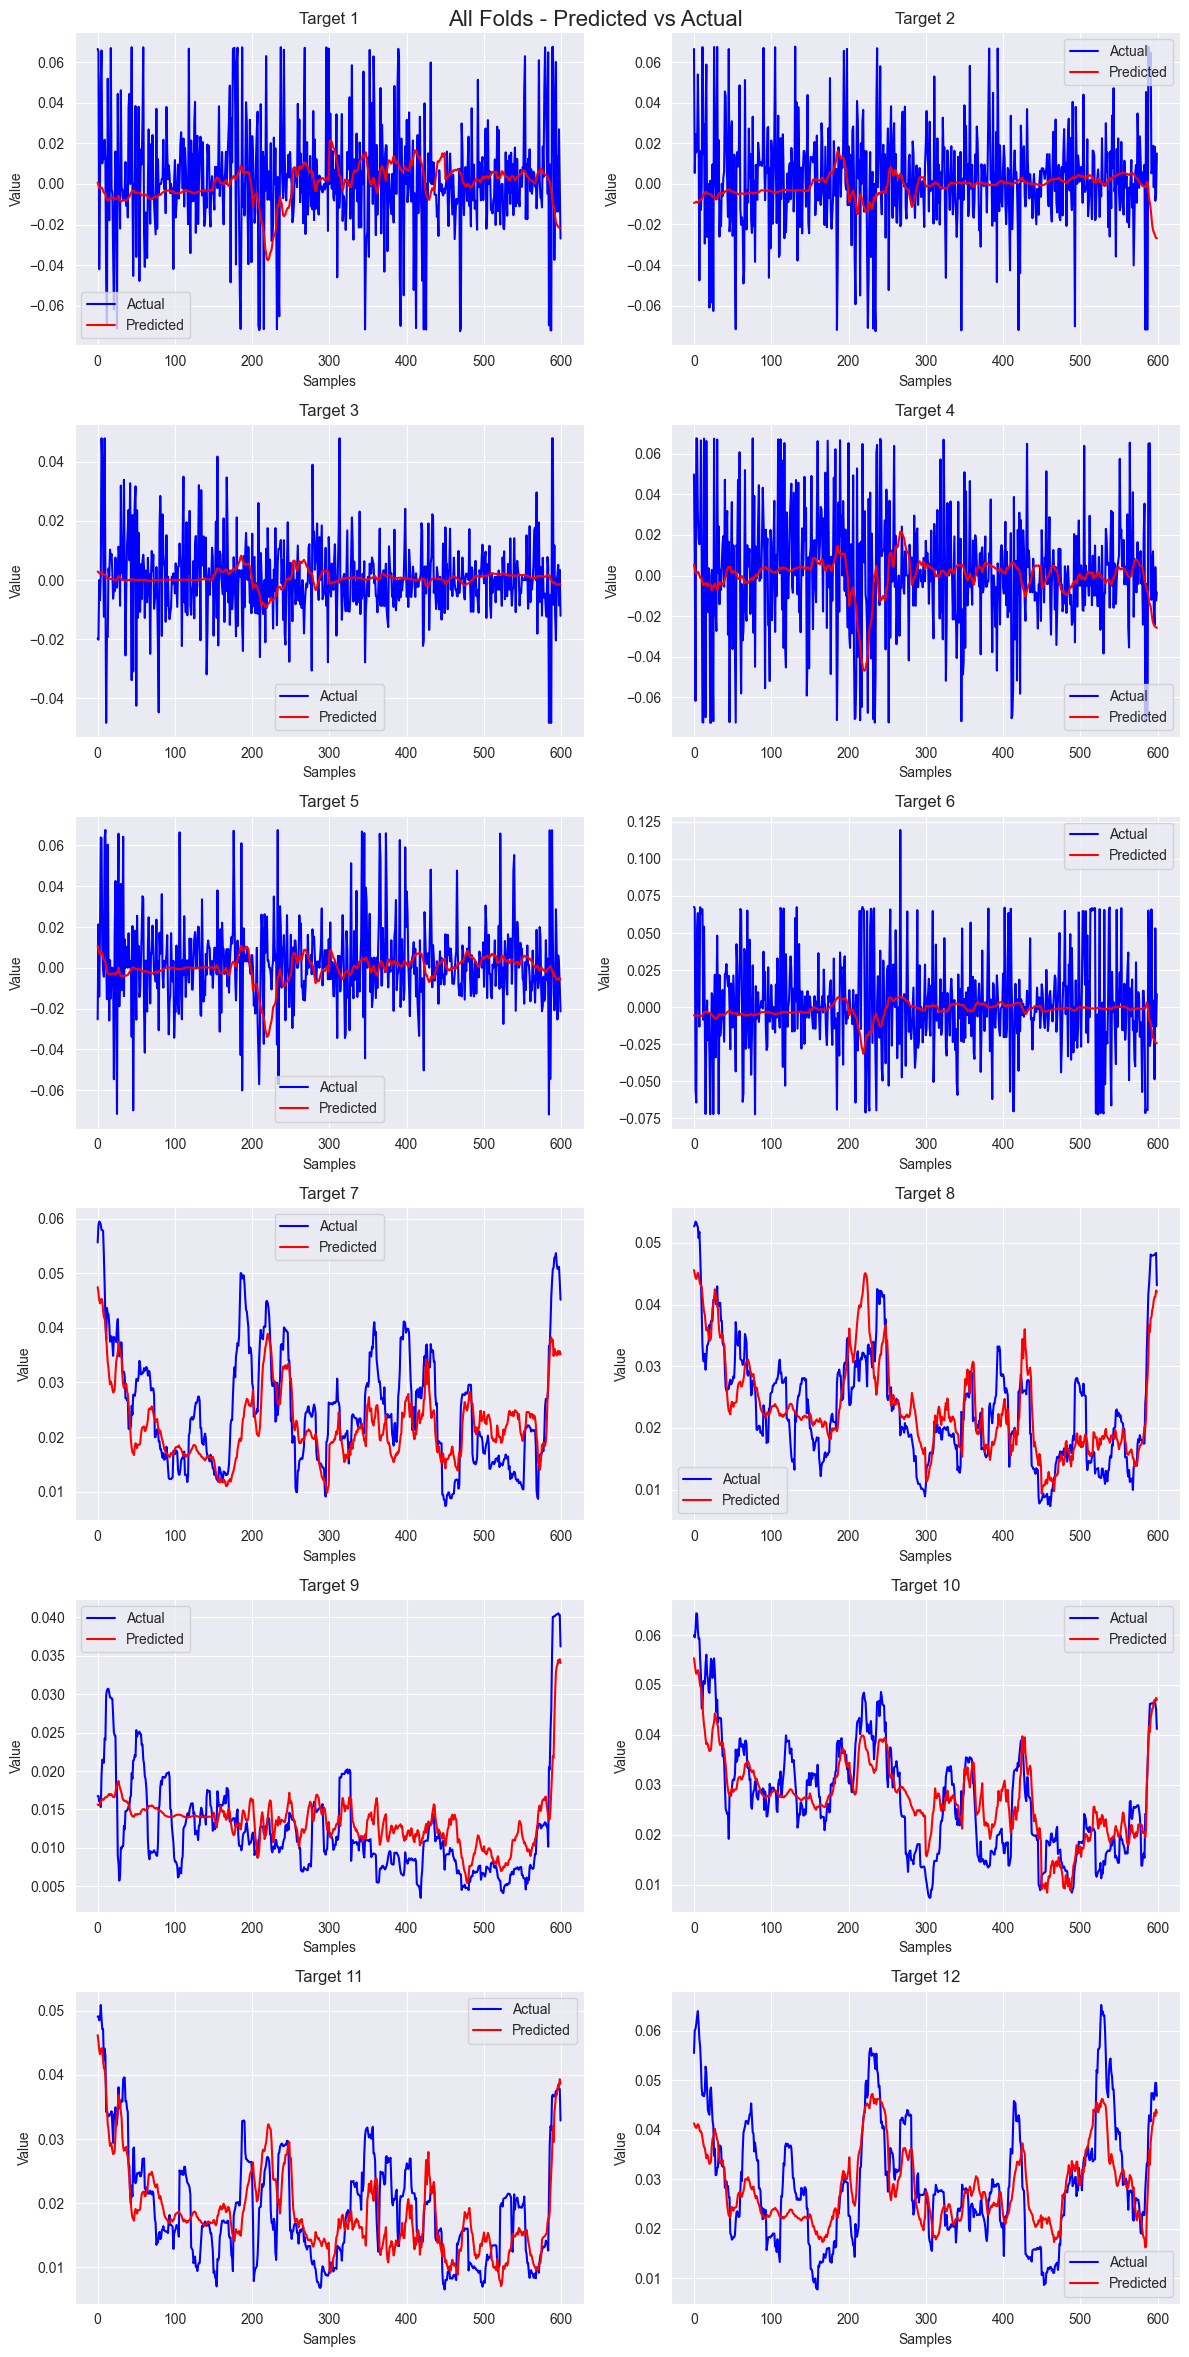

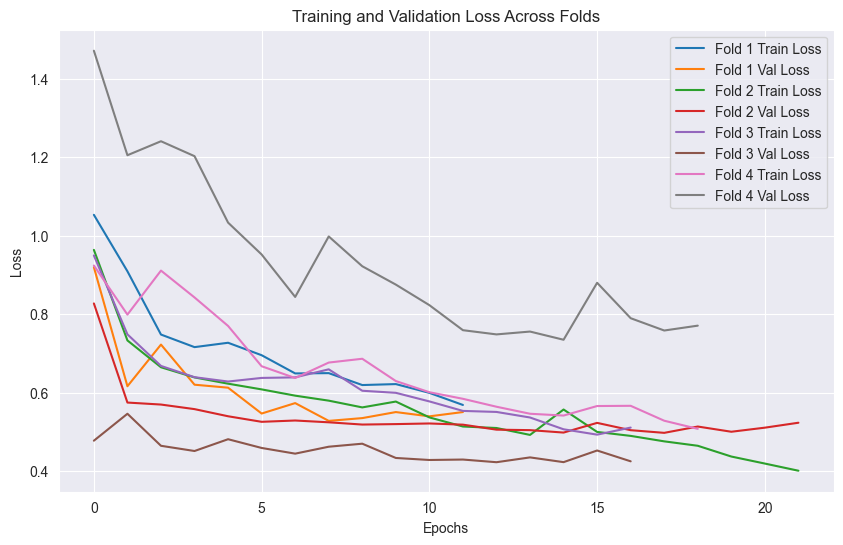

In [24]:
def prepare_data(X_np, y_np, train_idx, val_idx, batch_size):
    X_train_raw = X_np[train_idx].copy()
    X_val_raw = X_np[val_idx].copy()

    n_features = X_train_raw.shape[2]
    scalers_X = [StandardScaler() for _ in range(n_features)]

    for i in range(n_features):
        feature_train = X_train_raw[:, :, i].reshape(-1, 1)
        feature_val = X_val_raw[:, :, i].reshape(-1, 1)

        scalers_X[i].fit(feature_train)

        X_train_raw[:, :, i] = scalers_X[i].transform(feature_train).reshape(X_train_raw.shape[0], X_train_raw.shape[1])
        X_val_raw[:, :, i] = scalers_X[i].transform(feature_val).reshape(X_val_raw.shape[0], X_val_raw.shape[1])

    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_np[train_idx])
    y_val = y_scaler.transform(y_np[val_idx])

    X_train_tensor = torch.tensor(X_train_raw, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_raw, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, X_val_tensor, y_val_tensor, y_scaler


def train_one_fold(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=4):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_wts = None

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_wts = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses


def predict(model, val_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds.append(outputs.cpu())
    return torch.cat(preds, dim=0)


def plot_predictions(y_true, y_pred, title="Predicted vs Actual"):
    n_targets = y_true.shape[1]
    n_cols = 2
    n_rows = math.ceil(n_targets / n_cols)

    plt.figure(figsize=(6 * n_cols, 4 * n_rows))

    for i in range(n_targets):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.plot(y_true[:, i], label='Actual', color='blue')
        plt.plot(y_pred[:, i], label='Predicted', color='red')
        plt.title(f'Target {i+1}')
        plt.xlabel('Samples')
        plt.ylabel('Value')
        plt.legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_losses(train_losses, val_losses, n_splits):
    plt.figure(figsize=(10, 6))
    for i in range(n_splits):
        plt.plot(train_losses[i], label=f'Fold {i+1} Train Loss')
        plt.plot(val_losses[i], label=f'Fold {i+1} Val Loss')
    plt.title("Training and Validation Loss Across Folds")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def sharpe_ratio(pred_returns, true_returns):
    pred_mean = np.mean(pred_returns)
    pred_std = np.std(pred_returns)

    true_mean = np.mean(true_returns)
    true_std = np.std(true_returns)

    if pred_std == 0 or true_std == 0:
        return float('nan')

    sharpe_pred = pred_mean / pred_std
    sharpe_true = true_mean / true_std

    return sharpe_pred, sharpe_true


# === MAIN LOOP ===
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

X_np = X_tensor.numpy()
y_np = y_tensor.numpy()

cv_train_losses = []
cv_val_losses = []

all_y_true = []
all_y_pred = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_np)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    train_loader, val_loader, X_val_fold, y_val_fold, y_scaler = prepare_data(X_np, y_np, train_idx, val_idx, batch_size)

    activation_fn = get_activation_fn(config['activation'])
    print(f"Using activation function: {config['activation']}")

    criterion = get_loss_fn(config['loss'])
    print(f"Using loss function: {config['loss']}")

    model_fold = LSTMModel(
        input_size=input_size,
        hidden_size=hidden_size,
        output_size=output_size,
        num_layers=num_layers,
        dropout=config.get('dropout', 0.2),
        activation_fn=activation_fn
    ).to(device)

    optimizer = get_optimizer_fn(config['optimizer'], model_fold.parameters(), config['learning_rate'], config.get('momentum', 0.9))

    model_fold, train_losses, val_losses = train_one_fold(
        model_fold, train_loader, val_loader, criterion, optimizer, num_epochs, device
    )

    cv_train_losses.append(train_losses)
    cv_val_losses.append(val_losses)

    y_pred_fold = predict(model_fold, val_loader, device)
    y_pred_fold_np = y_scaler.inverse_transform(y_pred_fold.numpy())
    y_true_fold_np = y_scaler.inverse_transform(y_val_fold.numpy())

    all_y_pred.append(y_pred_fold_np)
    all_y_true.append(y_true_fold_np)

# === After all folds ===
y_pred_all = np.vstack(all_y_pred)
y_true_all = np.vstack(all_y_true)

plot_predictions(y_true_all, y_pred_all, title=f"All Folds - Predicted vs Actual")
plot_losses(cv_train_losses, cv_val_losses, n_splits)

 <big>Training<big>